# Tutorial 4: Pipeline debugging and benchmarking

When creating your own end-to-end deep learning workflow, things may go wrong anywhere along the way, it's very important to access the data after the pipeline and examine the correctness of pipeline operations. Furthermore, pipeline may be too slow to keep gpu busy, users may need to benchmark the pipeline speed to decide whether to move some operation to gpu.

In this tutorial, we are going to show you how to access pipeline results and do pipeline benchmarking. We will use the same pipeline as tutorial 3.

## define the pipeline (same as tutorial 2)

In [1]:
from fastestimator.pipeline.augmentation import Augmentation2D
from fastestimator.util.op import TensorOp
from fastestimator.dataset.mnist import load_data
from fastestimator.util.op import NumpyOp
from fastestimator.record.preprocess import ImageReader
import fastestimator as fe
import numpy as np
import os
import tensorflow as tf

class Rescale(NumpyOp):
    def forward(self, data, state):
        data = (data - 127.5) / 127.5
        return data

class Resize(TensorOp):
    def __init__(self, inputs, outputs, size):
        super().__init__(inputs=inputs, outputs=outputs)
        self.size = size
    
    def forward(self, data, state):
        data = tf.image.resize(data, self.size)
        return data

train_csv, eval_csv, data_path = load_data()

print("image data is generated in {}".format(data_path))

writer = fe.RecordWriter(save_dir=os.path.join(data_path, "FEdata"),
                         train_data=train_csv,
                         validation_data=eval_csv,
                         ops=[ImageReader(inputs="x", parent_path=data_path, grey_scale=True), 
                              Rescale(outputs="x")])

pipeline = fe.Pipeline(data=writer,
                       batch_size=32,
                       ops=[Resize(inputs="x", size=(30, 30), outputs="x"),
                            Augmentation2D(outputs="x", mode="train", rotation_range=15)])

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


image data is generated in /var/folders/5g/d_ny7h211cj3zqkzrtq01s480000gn/T/.fe/Mnist


## access the pipeline results

`pipeline.show_results` is built for accessing the pipeline data, for example, if users want to access single batch of pipeline data on epoch 0 during training:

In [2]:
result = pipeline.show_results(current_epoch=0, mode="train", num_steps=1)

x = result[0]["x"]
y = result[0]["y"]
print("shape of feature x is {}".format(x.shape))
print("shape of feature y is {}".format(y.shape))

FastEstimator: Reading non-empty directory: /var/folders/5g/d_ny7h211cj3zqkzrtq01s480000gn/T/.fe/Mnist/FEdata
FastEstimator: Found 60000 examples for train in /var/folders/5g/d_ny7h211cj3zqkzrtq01s480000gn/T/.fe/Mnist/FEdata/train_summary0.json
FastEstimator: Found 10000 examples for eval in /var/folders/5g/d_ny7h211cj3zqkzrtq01s480000gn/T/.fe/Mnist/FEdata/eval_summary0.json
shape of feature x is (32, 30, 30, 1)
shape of feature y is (32,)


ground truth label is 3
ground truth label is 5
ground truth label is 5
ground truth label is 6


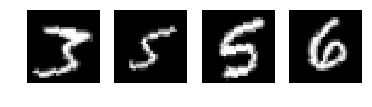

In [3]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 4)
for i in range(4):
    axes[i].axis('off')
    axes[i].imshow(np.squeeze(x[i]), cmap='gray')
    print("ground truth label is {}".format(y[i]))

## benchmark pipeline speed

`pipeline.benchmark` can be used to benchmark the pipeline speed, for example, if users want to benchmark on epoch 0 during training for 2000 steps (batches).

In [6]:
pipeline.benchmark(current_epoch=0,mode="train", num_steps=1500)

FastEstimator: Reading non-empty directory: /var/folders/5g/d_ny7h211cj3zqkzrtq01s480000gn/T/.fe/Mnist/FEdata
FastEstimator: Found 60000 examples for train in /var/folders/5g/d_ny7h211cj3zqkzrtq01s480000gn/T/.fe/Mnist/FEdata/train_summary0.json
FastEstimator: Found 10000 examples for eval in /var/folders/5g/d_ny7h211cj3zqkzrtq01s480000gn/T/.fe/Mnist/FEdata/eval_summary0.json
FastEstimator: Step: 100, Epoch: 0, Batch Size 32, Example/sec 21609.71
FastEstimator: Step: 200, Epoch: 0, Batch Size 32, Example/sec 20687.99
FastEstimator: Step: 300, Epoch: 0, Batch Size 32, Example/sec 20598.51
FastEstimator: Step: 400, Epoch: 0, Batch Size 32, Example/sec 20761.09
FastEstimator: Step: 500, Epoch: 0, Batch Size 32, Example/sec 21411.01
FastEstimator: Step: 600, Epoch: 0, Batch Size 32, Example/sec 21501.51
FastEstimator: Step: 700, Epoch: 0, Batch Size 32, Example/sec 19981.62
FastEstimator: Step: 800, Epoch: 0, Batch Size 32, Example/sec 21540.19
FastEstimator: Step: 900, Epoch: 0, Batch Size